In [4]:
import os, sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1" 
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")

### Load dataset info

In [5]:
path_to_train = './data/train/'
data = pd.read_csv('./data/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

### Create datagenerator

In [10]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        image_red_ch = np.array(Image.open(path+'_red.png'))
        image_yellow_ch = np.array(Image.open(path+'_yellow.png'))
        image_green_ch = np.array(Image.open(path+'_green.png'))
        image_blue_ch = np.array(Image.open(path+'_blue.png'))

        image_red_ch += (image_yellow_ch/2).astype(np.uint8) 
        image_green_ch += (image_yellow_ch/2).astype(np.uint8)

        image = np.stack((
            image_red_ch, 
            image_green_ch, 
            image_blue_ch), -1)
        image = resize(image, (shape[0], shape[1]), mode='reflect')
        return image
                
            
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug


### Show data

In [11]:
# create train datagen
train_datagen = data_generator.create_train(
    train_dataset_info, 5, (299,299,3), augument=True)

min: 0.0, max: 1.0


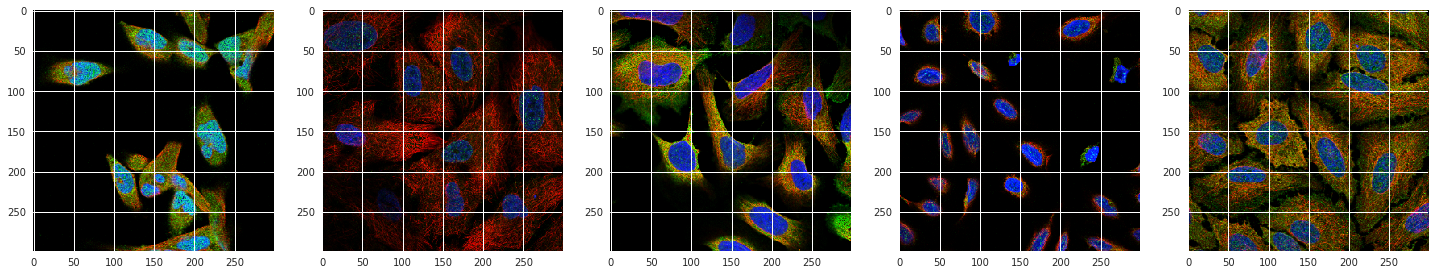

In [12]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

### Create model

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
import tensorflow as tf

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)
    
    model = Sequential()
    model.add(pretrain_model)
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_out))
    model.add(Activation('sigmoid'))
    return model

In [14]:
keras.backend.clear_session()

tfconfig = tfconfig = tf.ConfigProto(
                gpu_options=tf.GPUOptions(allow_growth=True)
            )
sess = tf.Session(config=tfconfig)
K.set_session(sess)
    
model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(1e-04),
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
activation_204 (Activation)  (None, 98304)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              100664320 
_________________________________________________________________
activation_205 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
__________

### Train model

In [15]:
epochs = 100; batch_size = 32
checkpointer = ModelCheckpoint(
    './working/InceptionResNetV2.model', 
    verbose=2, 
    save_best_only=True)

# split and suffle data 
np.random.seed(2018)
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes = indexes[:27500]
valid_indexes = indexes[27500:]

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (299,299,3), augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[valid_indexes], 100, (299,299,3), augument=False)

# train model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=epochs, 
    verbose=1,
    workers=20, 
    use_multiprocessing=True,
    callbacks=[checkpointer])

Epoch 1/100
100/100 [==============================] - 288s 3s/step - loss: 3.0750 - acc: 0.4113 - val_loss: 8.4433 - val_acc: 0.4200

Epoch 00001: val_loss improved from inf to 8.44329, saving model to ./working/InceptionResNetV2.model
Epoch 2/100
100/100 [==============================] - 147s 1s/step - loss: 2.3152 - acc: 0.5747 - val_loss: 6.2402 - val_acc: 0.4000

Epoch 00002: val_loss improved from 8.44329 to 6.24023, saving model to ./working/InceptionResNetV2.model
Epoch 3/100
100/100 [==============================] - 154s 2s/step - loss: 2.1226 - acc: 0.6234 - val_loss: 6.5111 - val_acc: 0.4200

Epoch 00003: val_loss did not improve from 6.24023
Epoch 4/100
100/100 [==============================] - 152s 2s/step - loss: 1.9682 - acc: 0.5981 - val_loss: 5.4501 - val_acc: 0.2800

Epoch 00004: val_loss improved from 6.24023 to 5.45006, saving model to ./working/InceptionResNetV2.model
Epoch 5/100
100/100 [==============================] - 146s 1s/step - loss: 1.8739 - acc: 0.616

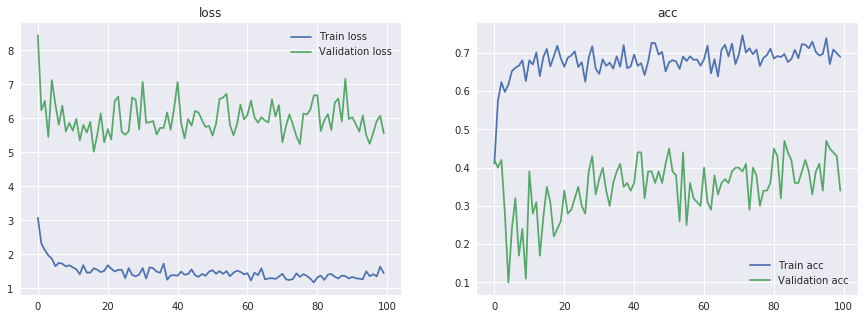

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
ax[0].legend()
ax[1].legend()

### Create submit

In [17]:
submit = pd.read_csv('./data/sample_submission.csv')

In [18]:
%%time
predicted = []
for name in tqdm(submit['Id']):
    path = os.path.join('./data/test/', name)
    image = data_generator.load_image(path, (299,299,3))
    score_predict = model.predict(image[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict>=0.5]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

100%|██████████| 11702/11702 [17:13<00:00, 11.32it/s]

CPU times: user 5h 8min 9s, sys: 26min 7s, total: 5h 34min 16s
Wall time: 17min 13s


In [19]:
submit['Predicted'] = predicted
submit.to_csv('submission.csv', index=False)